#  Factors that Influence Fan Ratings of Formula One Games

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import scipy.stats
import pylab
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
%matplotlib inline


In [2]:
#load and explore rating data 
ratingdf = pd.read_csv('./Data/fan_rating.csv', delimiter=',')
#ratingdf.head()
#rating.describe()
#rating.gp.unique()
#plt.hist(ratingdf.rating,bins=20)


In [3]:
#overtake data 
ot = pd.read_csv('./Data/overtaking.csv', delimiter=',',encoding = "ISO-8859-1")
ot['SCLaps'].fillna(0, inplace=True)
ot.describe()

#Merge overtake and rating data
df1 = pd.merge(ratingdf,ot, on = ['year','gp'] , how = 'right')
df1.drop(['raceNum'], axis = 1,inplace=True)
#df1.head()

In [4]:
#Championship data
cp = pd.read_csv('./Data/clinchedChamp.csv', delimiter=',',encoding = "ISO-8859-1")
df2 = pd.merge(df1,cp, on = ['year'] , how = 'left')
df2['totalrace'] = df2.groupby('year')['Race'].transform(max)

#create a column as indicator for whether championship is clinched
df2['Clinched'] = 'No'
df2.totalrace - df2.roundsLeft
df2.loc[df2.Race >= df2.totalrace - df2.roundsLeft, ['Clinched'] ] = 'Yes'
#df2.Clinched.describe()


In [5]:
# game results 
races = pd.read_csv('./Data/formula-1-race-data-19502017/races.csv', delimiter=',',encoding = "ISO-8859-1")
results = pd.read_csv('./Data/formula-1-race-data-19502017/results.csv', delimiter=',',encoding = "ISO-8859-1")
lapTimes = pd.read_csv('./Data/formula-1-race-data-19502017/lapTimes.csv', delimiter=',',encoding = "ISO-8859-1")
circuits = pd.read_csv('./Data/formula-1-race-data-19502017/circuits.csv', delimiter=',',encoding = "ISO-8859-1")
lapTimes.describe()
laplead = lapTimes.copy()
laplead = laplead[laplead.position == 1]
laplead.head()

laplead['prevlap'] = laplead.lap -1

test = pd.merge(laplead,laplead,left_on=['raceId','lap'], right_on=['raceId','prevlap'], how = 'inner',suffixes=('_race', '_next'))

#create a column as indicator for whether lap leader has changed 
test['change'] = 0
test.loc[test.driverId_race != test.driverId_next, ['change'] ] = 1
leadchange = test.groupby('raceId')['change'].sum()

temp = leadchange.to_frame().reset_index()
len(lapTimes['raceId'].unique())


426

In [6]:
leadchangedf = pd.merge(temp, races,on ='raceId', how = 'left')
leadchangedf.head()
df2 = pd.merge(df2, leadchangedf,on = ['year','gp'],how = 'left')


In [7]:
#check whether gp wording is consitent across datasets 
otgp = df2.gp.unique()
#print(otgp)
leadgp = list(leadchangedf.gp.unique())
#print(leadgp)

#set(leadgp).symmetric_difference(set(otgp))

# Does F1 become less interesting over the years?

Text(0, 0.5, 'Rating')

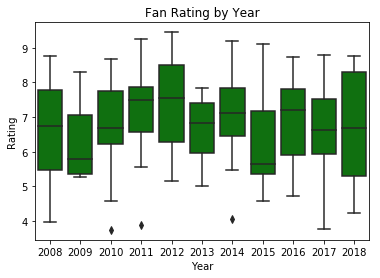

In [8]:
#plot rating by year 
sns.boxplot(x='year', y='rating', data=ratingdf,color= 'green')
plt.title("Fan Rating by Year")
plt.xlabel("Year")
plt.ylabel("Rating")

# Which Grand Prix are the most and least interesting? 

Text(36.625, 0.5, 'Rating')

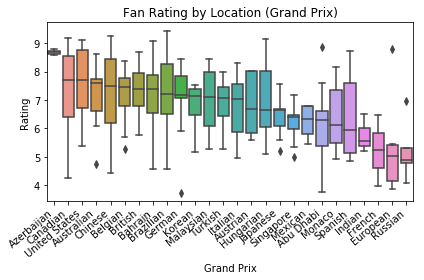

In [9]:
grouped = ratingdf.groupby("gp")
users_sorted_average = pd.DataFrame({col:vals['rating'] for col,vals in grouped}).median().sort_values(ascending=False)   
ax = sns.boxplot(x='gp', y='rating', data=ratingdf, order=users_sorted_average.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Fan Rating by Location (Grand Prix)")
plt.tight_layout()
plt.xlabel("Grand Prix")
plt.ylabel("Rating")

Text(33.0, 0.5, 'Grand Prix')

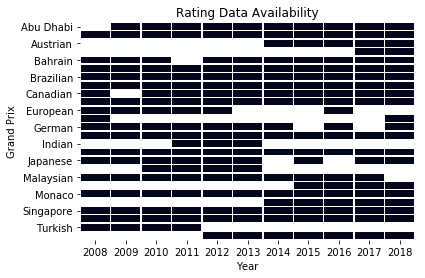

In [10]:
ratingdf['exist_ind'] = 10
ratingdf.describe()
ratingm = ratingdf.pivot_table(index='gp', columns='year',values= 'exist_ind')  
ax = sns.heatmap(ratingm, cbar = False, linewidths=.5)

plt.title("Rating Data Availability")
plt.xlabel("Year")
plt.ylabel("Grand Prix")


In [11]:
#ratingdf.head()


# Do wet tracks generally have higher rating? 

Text(0, 0.5, 'Track Condition')

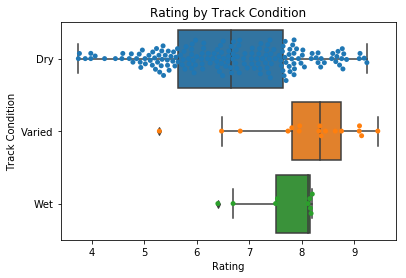

In [12]:

df2.Weather.value_counts()
sns.boxplot(y='Weather', x='rating', data=df2)
sns.swarmplot(y='Weather', x='rating', data=df2)

plt.title("Rating by Track Condition")
plt.xlabel("Rating")
plt.ylabel("Track Condition")

# Does the occurence of safety car mean higher rating? 

In [13]:
df2['SCind'] = 0
df2.loc[df2.SCLaps > 0,['SCind']] = 'Yes'
df2.loc[df2.SCLaps == 0,['SCind']] = 'No'
#print (df2.loc[df2.year == 2017,['SCLaps', 'SCind']])

Text(0, 0.5, 'Rating')

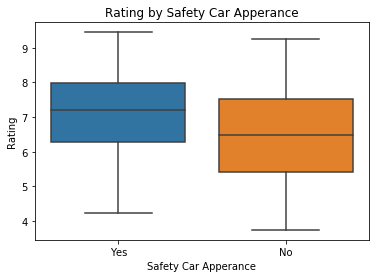

In [14]:
df2['SCind'].value_counts()
sns.boxplot(x='SCind', y='rating', data=df2)
plt.title("Rating by Safety Car Apperance")
plt.xlabel("Safety Car Apperance")
plt.ylabel("Rating")

# Do more overtakes mean higher rating?

In [15]:
#plt.hist(df2['Overtakes'])


Text(0, 0.5, 'Rating')

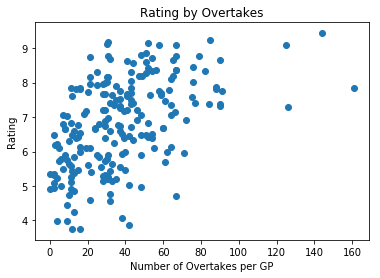

In [16]:

plt.scatter(x='Overtakes', y='rating', data=df2)
plt.title("Rating by Overtakes")
plt.xlabel("Number of Overtakes per GP")
plt.ylabel("Rating")

Text(0, 0.5, 'Rating')

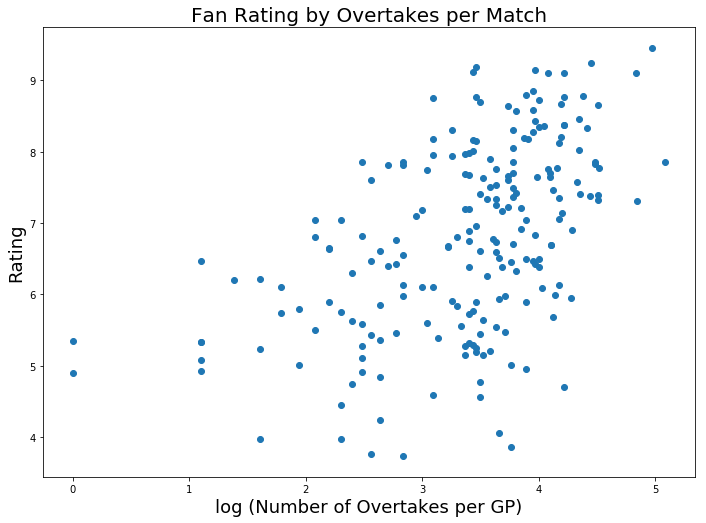

In [17]:
# Log Transformation 
df2['Overtakes_log'] = np.log((1+ df2['Overtakes']))
#plt.hist(df2['Overtakes_log'])

# Plot after log-transformation 
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

plt.scatter(x='Overtakes_log', y='rating', data=df2)
plt.title("Fan Rating by Overtakes per Match",fontsize=20)
plt.xlabel("log (Number of Overtakes per GP)",fontsize=18)
plt.ylabel("Rating",fontsize=18)

# Championship Claimed. Are the remaining games less interesting?

Text(0, 0.5, 'Rating')

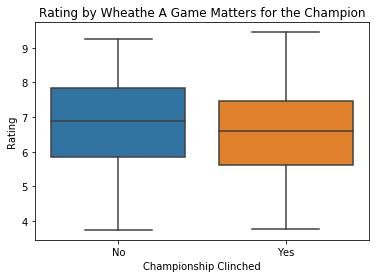

In [18]:

sns.boxplot(x='Clinched', y='rating', data=df2)
plt.title("Rating by Wheathe A Game Matters for the Champion")
plt.xlabel("Championship Clinched")
plt.ylabel("Rating")

# Competitve Balance  (Lead Change, Margin of Victory)

Text(0, 0.5, 'Rating')

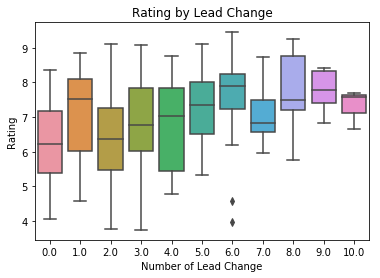

In [19]:
# Count Lead Change per GP 
sns.boxplot(x='change', y='rating', data=df2)
plt.title("Rating by Lead Change")
plt.xlabel("Number of Lead Change")
plt.ylabel("Rating")


In [20]:
# Calculate margin of victory 

victory = results[(results.positionOrder == 1) | (results.positionOrder == 2)]

marginV = victory.groupby('raceId')['milliseconds'].apply(lambda g: g.max()- g.min())
marginV =  marginV.to_frame().reset_index()
marginV.columns = ['raceId', 'margin']

marginV = pd.merge(marginV, races,on ='raceId', how = 'left')
marginV = marginV[['year','gp','margin']]
df2 = pd.merge(df2, marginV,on = ['year','gp'],how = 'left')
df2.loc[df2.margin == 0,'margin']= np.nan # change margin to NA when not available

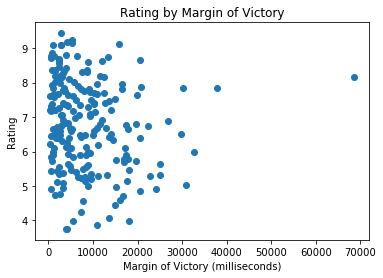

In [21]:

plt.scatter(x='margin', y='rating', data=df2)
plt.title("Rating by Margin of Victory")
plt.xlabel("Margin of Victory (milliseconds)")
plt.ylabel("Rating")
plt.show()

In [22]:
#plt.hist(df2['margin'])
df2['margin_log'] = np.log((1+ df2['margin']))
#plt.hist(df2['margin_log'])

In [23]:
#df2.loc[df2['margin']>50000,:]
#sns.boxplot(x='year', y='margin', data=df2)
#win margin decrease over the years 

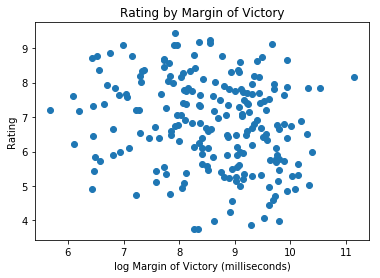

In [24]:

plt.scatter(x='margin_log', y='rating', data=df2)
plt.title("Rating by Margin of Victory")
plt.xlabel("log Margin of Victory (milliseconds)")
plt.ylabel("Rating")
plt.show()

# Does Pit Stops Influence Rating?

In [25]:
## Analyze Pit Stops 
pit = pd.read_csv('./Data/formula-1-race-data-19502017/pit_stops.csv', delimiter=',')

In [26]:
#pit.head()

In [27]:
pitdf = pd.merge(pit, races,on='raceId', how = 'left') # pit only available after 2011

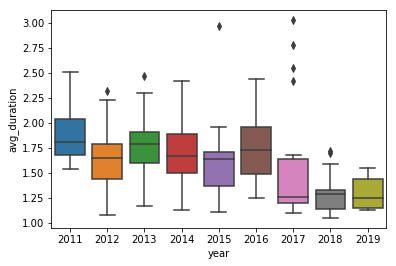

In [28]:
pitdur = pitdf.groupby(['year','round'])['stop'].mean().reset_index(name= 'avg_duration')
#pitdur.head()
sns.boxplot(x = 'year', y = 'avg_duration', data = pitdur)
#pitdf.isnull().sum()

In [29]:
pitcount = pitdf.groupby(['raceId','driverId'])['stop'].max().reset_index(name= 'stopcount')
pitcount.head()
temp1 = pitcount.groupby(['raceId','stopcount']).size().reset_index(name= 'driverusingStops')
temp1.head()
Pitdiversty = temp1.groupby('raceId')['stopcount'].size().reset_index(name= 'NPitStrategy')
#Pitdiversty.describe()

Teams stop less over the years

In [30]:
df3 = pd.merge(df2,Pitdiversty, on = ['raceId'] , how = 'left')

# Does Rating Increase with Speed?

In [31]:
fastest = lapTimes.groupby('raceId')['milliseconds'].min().reset_index(name= 'fastestTime')
df4 = pd.merge(df3, fastest, on = ['raceId'] , how = 'left')

In [32]:
#ax = sns.boxplot(x = 'year', y = 'fastestTime', data = df4.loc[pd.notnull(df4['fastestTime']),:])
#plt.scatter(x='fastestTime', y='rating', data=df4)
#plt.hist(df4['fastestTime'])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


# Competitive Balance (Spearman Correlation between Qualifying Results and Finals)

In [33]:
qualify = pd.read_csv('./Data/formula-1-race-data-19502017/qualifying.csv', delimiter=',',encoding = "ISO-8859-1")
qualify.drop(['q1','q2','q3'], axis = 1,inplace=True)

qualify = qualify.rename(index=str, columns={"position": "position_qualify"})
#qualify.head()

In [34]:
rank = results[['positionOrder','raceId', 'driverId']]
temp = pd.merge(qualify,rank, on = ['raceId', 'driverId'] , how = 'left')
spear = temp.loc[pd.notnull(temp['position_qualify']),:]

In [35]:
spear_list = []
for id in list(spear.raceId.unique()):
    temp0 = [id]
    temp1 = spear.loc[spear['raceId'] == id,:]
    spear_coeff = list(scipy.stats.pearsonr(temp1['position_qualify'], temp1['positionOrder']))
    spear_list.append(spear_coeff + temp0)
    

In [36]:
spear_coef = pd.DataFrame(spear_list, columns = [ 'spear', 'spear_p','raceId'])

In [37]:
df5 = pd.merge(df4, spear_coef, on = ['raceId'] , how = 'left')
#df5.head()

Text(0, 0.5, 'Rating')

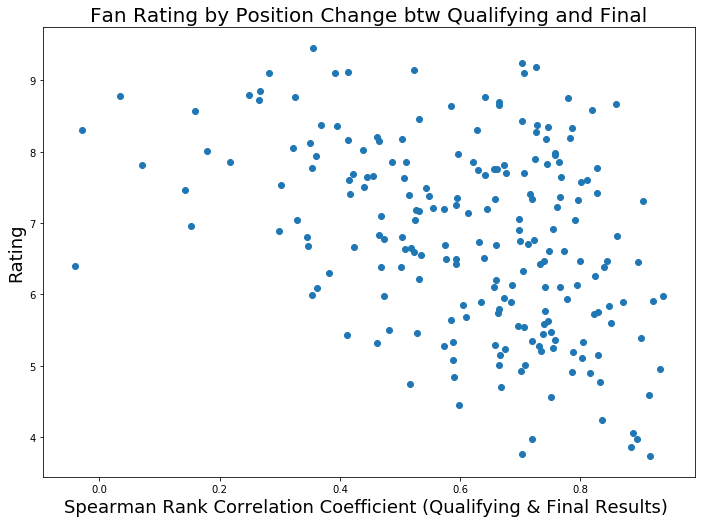

In [38]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.scatter(x = 'spear', y = 'rating',data= df5)
plt.title("Fan Rating by Position Change btw Qualifying and Final",fontsize=20)
plt.xlabel("Spearman Rank Correlation Coefficient (Qualifying & Final Results) ",fontsize=18)
plt.ylabel("Rating",fontsize=18)

# Competitive  Balance (Driver/Team Standing at Each Match)

In [39]:
driverStandings = pd.read_csv('./Data/formula-1-race-data-19502017/driverStandings.csv', delimiter=',',encoding = "ISO-8859-1")
constructorStandings = pd.read_csv('./Data/formula-1-race-data-19502017/constructorStandings.csv', delimiter=',',encoding = "ISO-8859-1")
#driverStandings.head()

In [40]:
hhi_list = []
for id in list(driverStandings.raceId.unique()):
    temp1 = driverStandings.loc[driverStandings['raceId'] == id,'points']
    total = temp1.sum()
    hhi_elements = [(value/total)**2 for value in temp1]
    hhi = sum(hhi_elements)
    hhi_list.append([hhi, id])
    
hhi_list_team = []
for id in list(constructorStandings.raceId.unique()):
    temp1 = constructorStandings.loc[constructorStandings['raceId'] == id,'points']
    total = temp1.sum()
    hhi_elements = [(value/total)**2 for value in temp1]
    hhi = sum(hhi_elements)
    hhi_list_team.append([hhi, id])

In [41]:
hhidf = pd.DataFrame(hhi_list, columns = [ 'hhi', 'raceId'])
hhidf ['log_hhi'] = np.log(hhidf['hhi'] )
hhidf_team = pd.DataFrame(hhi_list_team, columns = [ 'hhi_team', 'raceId'])
hhidf_team['log_hhi_team'] = np.log(hhidf_team['hhi_team'] )

In [42]:
#plt.hist(hhidf_team['log_hhi_team'])

In [43]:
df6 = pd.merge(df5, hhidf, on = ['raceId'] , how = 'left')
df7 = pd.merge(df6, hhidf_team, on = ['raceId'] , how = 'left')

Text(0, 0.5, 'HHI-Index')

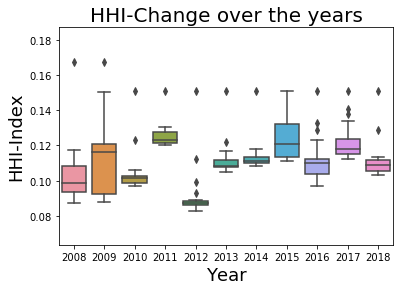

In [44]:
plt.scatter(x = 'year', y = 'hhi',data= df6.loc[df6['year']>=2008,:],c = 'year')

sns.boxplot(x = 'year', y = 'hhi',data= df6.loc[df6['year']>=2008,:])
plt.title("HHI-Change over the years",fontsize = 20)
plt.xlabel("Year",fontsize = 18)
plt.ylabel("HHI-Index", fontsize = 18)

In [45]:
temp = df6.loc[df6['round'].notnull() ,:]
#plt.scatter(y = 'rating', x = 'log_hhi', data= temp.loc[ temp['round'] > 1,:])

Text(0, 0.5, 'HHI')

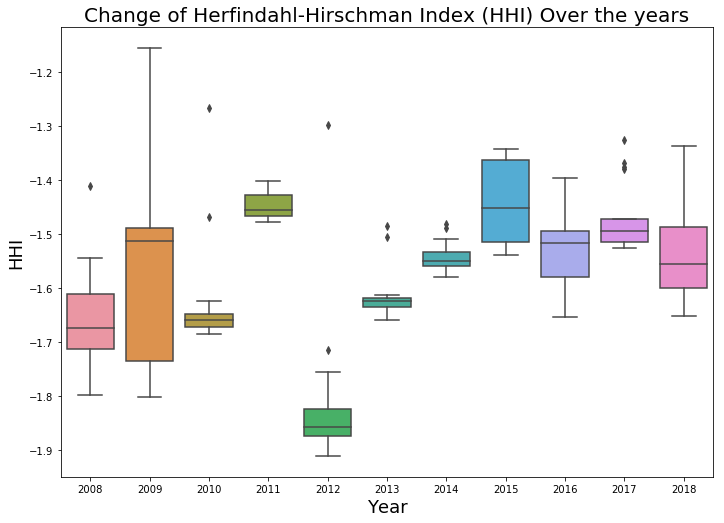

In [46]:
#plt.scatter(x = 'year', y = 'hhi',data= df6.loc[df6['year']>=2008,:],c = 'year')
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(x = 'year', y = 'log_hhi_team',data= df7.loc[df7['year']>=2008,:])
plt.title("Change of Herfindahl-Hirschman Index (HHI) Over the years",fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("HHI", fontsize = 18)

In [47]:
temp = df7.loc[df7['round'].notnull() ,:]
#plt.scatter(y = 'rating', x = 'log_hhi_team', data= temp.loc[ temp['round'] > 1,:])

In [48]:
df7.to_csv (r'./Data/df7.csv', index = None, header=True,encoding='utf-8')

Text(0, 0.5, 'HHI')

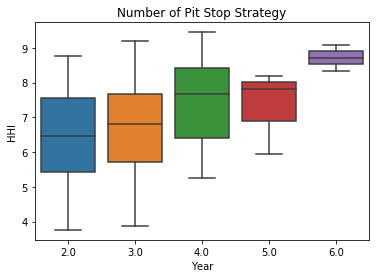

In [49]:
sns.boxplot(x = 'NPitStrategy', y = 'rating',data= df7.loc[df7['year']>=2008,:])
plt.title("Number of Pit Stop Strategy")
plt.xlabel("Year")
plt.ylabel("HHI")